Lambda School Data Science, Unit 2: Predictive Modeling

# Kaggle Challenge, Module 4

### Objectives
- Do **cross-validation** with independent test set
- Use scikit-learn for **hyperparameter optimization**

### Setup

#### If you're using [Anaconda](https://www.anaconda.com/distribution/) locally

Install required Python packages, if you haven't already:

[category_encoders](http://contrib.scikit-learn.org/categorical-encoding/), version >= 2.0  
`conda install -c conda-forge category_encoders`

[xgboost](https://xgboost.readthedocs.io/en/latest/)  
`conda install -c conda-forge xgboost` 

In [1]:
# If you're in Colab...
import os, sys
in_colab = 'google.colab' in sys.modules

if in_colab:
    # Install required python packages:
    # category_encoders, version >= 2.0
    # eli5, version >= 0.9
    # pandas-profiling, version >= 2.0
    # plotly, version >= 4.0
    !pip install --upgrade category_encoders eli5 pandas-profiling plotly
    
    # Pull files from Github repo
    os.chdir('/content')
    !git init .
    !git remote add origin https://github.com/LambdaSchool/DS-Unit-2-Kaggle-Challenge.git
    !git pull origin master
    
    # Change into directory for module
    os.chdir('module4')

## NYC

We're going back to one of our **New York City** real estate datasets. 



In [2]:
import numpy as np
import pandas as pd

# Read New York City apartment rental listing data
df = pd.read_csv('../data/renthop-nyc.csv')
assert df.shape == (49352, 34)

# Remove the most extreme 1% prices,
# the most extreme .1% latitudes, &
# the most extreme .1% longitudes
df = df[(df['price'] >= np.percentile(df['price'], 0.5)) & 
        (df['price'] <= np.percentile(df['price'], 99.5)) & 
        (df['latitude'] >= np.percentile(df['latitude'], 0.05)) & 
        (df['latitude'] < np.percentile(df['latitude'], 99.95)) &
        (df['longitude'] >= np.percentile(df['longitude'], 0.05)) & 
        (df['longitude'] <= np.percentile(df['longitude'], 99.95))]

# Do train/test split
# Use data from April & May 2016 to train
# Use data from June 2016 to test
df['created'] = pd.to_datetime(df['created'], infer_datetime_format=True)
cutoff = pd.to_datetime('2016-06-01')
train = df[df.created < cutoff]
test  = df[df.created >= cutoff]

# Wrangle train & test sets in the same way
def engineer_features(df):
    
    # Avoid SettingWithCopyWarning
    df = df.copy()
        
    # Does the apartment have a description?
    df['description'] = df['description'].str.strip().fillna('')
    df['has_description'] = df['description'] != ''

    # How long is the description?
    df['description_length'] = df['description'].str.len()

    # How many total perks does each apartment have?
    perk_cols = ['elevator', 'cats_allowed', 'hardwood_floors', 'dogs_allowed',
                 'doorman', 'dishwasher', 'no_fee', 'laundry_in_building',
                 'fitness_center', 'pre-war', 'laundry_in_unit', 'roof_deck',
                 'outdoor_space', 'dining_room', 'high_speed_internet', 'balcony',
                 'swimming_pool', 'new_construction', 'exclusive', 'terrace', 
                 'loft', 'garden_patio', 'common_outdoor_space', 
                 'wheelchair_access']
    df['perk_count'] = df[perk_cols].sum(axis=1)

    # Are cats or dogs allowed?
    df['cats_or_dogs'] = (df['cats_allowed']==1) | (df['dogs_allowed']==1)

    # Are cats and dogs allowed?
    df['cats_and_dogs'] = (df['cats_allowed']==1) & (df['dogs_allowed']==1)

    # Total number of rooms (beds + baths)
    df['rooms'] = df['bedrooms'] + df['bathrooms']
    
    # Extract number of days elapsed in year, and drop original date feature
    df['days'] = (df['created'] - pd.to_datetime('2016-01-01')).dt.days
    df = df.drop(columns='created')

    return df

train = engineer_features(train)
test = engineer_features(test)

In [3]:
import pandas_profiling
train.profile_report()

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


## Do cross-validation with independent test set

Let's take another look at [Sebastian Raschka's diagram of model evaluation methods.](https://sebastianraschka.com/blog/2018/model-evaluation-selection-part4.html) So far we've been using "**train/validation/test split**", but we have more options. 

Today we'll learn about "k-fold **cross-validation** with independent test set", for "model selection (**hyperparameter optimization**) and performance estimation."

<img src="https://sebastianraschka.com/images/blog/2018/model-evaluation-selection-part4/model-eval-conclusions.jpg" width="600">

<sup>Source: https://sebastianraschka.com/blog/2018/model-evaluation-selection-part4.html</sup>



The Scikit-Learn docs show a diagram of how k-fold cross-validation works, and explain the pros & cons of cross-validation versus train/validate/test split.

#### [Scikit-Learn User Guide, 3.1 Cross-validation](https://scikit-learn.org/stable/modules/cross_validation.html)

> When evaluating different settings (“hyperparameters”) for estimators, there is still a risk of overfitting on the test set because the parameters can be tweaked until the estimator performs optimally. This way, knowledge about the test set can “leak” into the model and evaluation metrics no longer report on generalization performance. To solve this problem, yet another part of the dataset can be held out as a so-called “validation set”: training proceeds on the training set, after which evaluation is done on the validation set, and when the experiment seems to be successful, final evaluation can be done on the test set.

> However, **by partitioning the available data into three sets, we drastically reduce the number of samples which can be used for learning the model, and the results can depend on a particular random choice for the pair of (train, validation) sets.**

> **A solution to this problem is a procedure called cross-validation (CV for short). A test set should still be held out for final evaluation, but the validation set is no longer needed when doing CV.** 

<img src="https://scikit-learn.org/stable/_images/grid_search_cross_validation.png" width="600">

> In the basic approach, called k-fold CV, the training set is split into k smaller sets. The following procedure is followed for each of the k “folds”:

> - A model is trained using $k-1$ of the folds as training data;
> - the resulting model is validated on the remaining part of the data (i.e., it is used as a test set to compute a performance measure such as accuracy).

> The performance measure reported by k-fold cross-validation is then the average of the values computed in the loop. **This approach can be computationally expensive, but does not waste too much data (as is the case when fixing an arbitrary validation set).**

### cross_val_score

How do we get started? According to the [Scikit-Learn User Guide](https://scikit-learn.org/stable/modules/cross_validation.html#computing-cross-validated-metrics), 

> The simplest way to use cross-validation is to call the [**`cross_val_score`**](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html) helper function

But, there's a quirk: For scikit-learn's cross-validation [**scoring**](https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter), higher is better. But for regression error metrics, lower is better. So scikit-learn multiplies regression error metrics by -1 to make them negative. That's why the value of the `scoring` parameter is `'neg_mean_absolute_error'`.

So, k-fold cross-validation with this dataset looks like this:

#### Linear Model

In [4]:
import category_encoders as ce
import numpy as np
from sklearn.feature_selection import f_regression, SelectKBest
from sklearn.impute import SimpleImputer
from sklearn.linear_model import Ridge
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

# Condo Sales
# target = 'SALE_PRICE'
# high_cardinality = ['SALE_DATE', 'NEIGHBORHOOD', 'ADDRESS']

# Apartment Rents
target = 'price'
high_cardinality = ['display_address', 'street_address', 'description']
features = train.columns.drop([target] + high_cardinality)
X_train = train[features]
y_train = train[target]

pipeline = make_pipeline(
    ce.OneHotEncoder(use_cat_names=True), 
    SimpleImputer(strategy='mean'), 
    SelectKBest(f_regression, k=10), 
    Ridge(alpha=1.0)
)

k = 3
scores = cross_val_score(pipeline, X_train, y_train, cv=k, 
                         scoring='neg_mean_absolute_error')
print(f'MAE for {k} folds:', -scores)

MAE for 3 folds: [709.71073719 700.6319256  699.68272256]


#### Random Forest

In [5]:
from sklearn.ensemble import RandomForestRegressor

features = train.columns.drop(target)
X_train = train[features]
y_train = train[target]

pipeline = make_pipeline(
    ce.TargetEncoder(min_samples_leaf=1, smoothing=1), 
    SimpleImputer(strategy='median'), 
    RandomForestRegressor(n_estimators=100, n_jobs=-1, random_state=42)
)

k = 3
scores = cross_val_score(pipeline, X_train, y_train, cv=k, 
                         scoring='neg_mean_absolute_error')
print(f'MAE for {k} folds:', -scores)

MAE for 3 folds: [392.28996182 404.92923235 388.97416404]


But the Random Forest has many hyperparameters. We mostly used the defaults, and arbitrarily chose `n_estimators`. Is it too high? Too low? Just right? How do we know?

In [6]:
print('Model Hyperparameters:')
print(pipeline.named_steps['randomforestregressor'])

Model Hyperparameters:
RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
                      oob_score=False, random_state=42, verbose=0,
                      warm_start=False)


"The universal tension in machine learning is between optimization and generalization; the ideal model is one that stands right at the border between underfitting and overfitting; between undercapacity and overcapacity. To figure out where this border lies, first you must cross it." —[Francois Chollet](https://books.google.com/books?id=dadfDwAAQBAJ&pg=PA114)

### Validation Curve

Let's try different parameter values, and visualize "the border between underfitting and overfitting." 

Using scikit-learn, we can make [validation curves](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.validation_curve.html), "to determine training and test scores for varying parameter values. This is similar to grid search with one parameter."

<img src="https://jakevdp.github.io/PythonDataScienceHandbook/figures/05.03-validation-curve.png">

<sup>Source: https://jakevdp.github.io/PythonDataScienceHandbook/05.03-hyperparameters-and-model-validation.html#Validation-curves-in-Scikit-Learn</sup>

Validation curves are awesome for learning about overfitting and underfitting. (But less useful in real-world projects, because we usually want to vary more than one parameter.)

For this example, let's see what happens when we vary the depth of a decision tree. (This will be faster than varying the number of estimators in a random forest.)

/home/ubuntu/anaconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


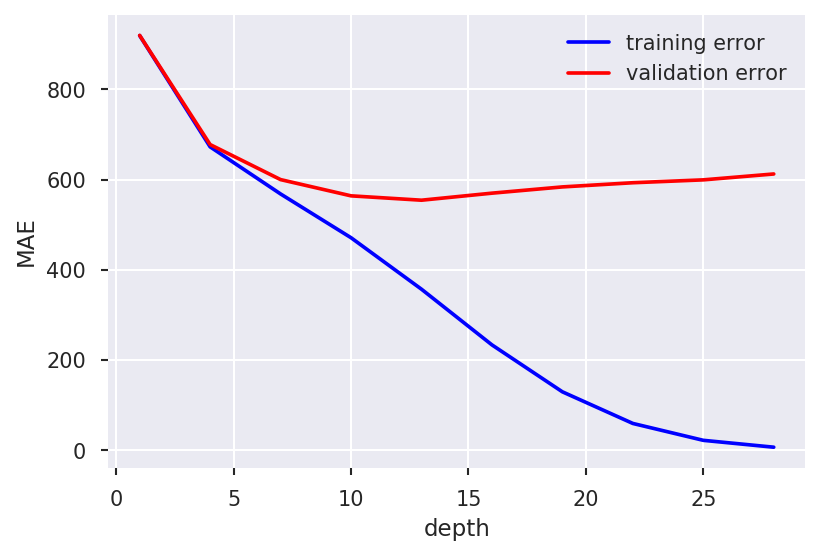

In [7]:
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.model_selection import validation_curve
from sklearn.tree import DecisionTreeRegressor

pipeline = make_pipeline(
    ce.OrdinalEncoder(), 
    SimpleImputer(), 
    DecisionTreeRegressor()
)

depth = range(1, 30, 3)
train_scores, val_scores = validation_curve(
    pipeline, X_train, y_train,
    param_name='decisiontreeregressor__max_depth', 
    param_range=depth, scoring='neg_mean_absolute_error', 
    cv=3,
    n_jobs=-1
)

plt.figure(dpi=150)
plt.plot(depth, np.mean(-train_scores, axis=1), color='blue', label='training error')
plt.plot(depth, np.mean(-val_scores, axis=1), color='red', label='validation error')
plt.xlabel('depth')
plt.ylabel('MAE')
plt.legend();

## Use scikit-learn for hyperparameter optimization

To vary multiple hyperparameters and find their optimal values, let's try **Randomized Search CV.**

#### [Scikit-Learn User Guide, 3.2 Tuning the hyper-parameters of an estimator](https://scikit-learn.org/stable/modules/grid_search.html)

> Hyper-parameters are parameters that are not directly learnt within estimators. In scikit-learn they are passed as arguments to the constructor of the estimator classes. 
>
> It is possible and recommended to search the hyper-parameter space for the best cross validation score.
>
> [`GridSearchCV`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html#sklearn.model_selection.GridSearchCV) exhaustively considers all parameter combinations, while [`RandomizedSearchCV`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html) can sample a given number of candidates from a parameter space with a specified distribution. 
>
> While using a grid of parameter settings is currently the most widely used method for parameter optimization, other search methods have more favourable properties. [`RandomizedSearchCV`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html) implements a randomized search over parameters, where each setting is sampled from a distribution over possible parameter values.
>
> Specifying how parameters should be sampled is done using a dictionary. Additionally, a computation budget, being the number of sampled candidates or sampling iterations, is specified using the `n_iter` parameter. 
>
> For each parameter, either a distribution over possible values or a list of discrete choices (which will be sampled uniformly) can be specified.
>
> This example uses the `scipy.stats` module, which contains many useful distributions for sampling parameters.

#### Linear Model

In [8]:
from scipy.stats import randint, uniform
from sklearn.model_selection import RandomizedSearchCV

features = train.columns.drop([target] + high_cardinality)
X_train = train[features]
y_train = train[target]

pipeline = make_pipeline(
    ce.OneHotEncoder(use_cat_names=True), 
    SimpleImputer(), 
    SelectKBest(f_regression), 
    Ridge()
)

param_distributions = {
    'simpleimputer__strategy': ['mean', 'median'], 
    'selectkbest__k': randint(1, len(X_train.columns)+1), 
    'ridge__alpha': uniform(1, 10), 
}

search = RandomizedSearchCV(
    pipeline, 
    param_distributions=param_distributions, 
    n_iter=100, 
    cv=5, 
    scoring='neg_mean_absolute_error', 
    verbose=10, 
    return_train_score=True, 
    n_jobs=-1
)

search.fit(X_train, y_train);

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    4.4s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    5.8s
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    7.8s
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    9.9s
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:   12.5s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:   15.2s
[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:   17.9s
[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:   21.0s
[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed:   24.6s
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:   28.1s
[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed:   32.1s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   35.5s
[Parallel(n_jobs=-1)]: Done 173 tasks      | elapsed:   

In [9]:
print('Best hyperparameters', search.best_params_)
print('Cross-validation MAE', -search.best_score_)

Best hyperparameters {'ridge__alpha': 1.3965316239717231, 'selectkbest__k': 36, 'simpleimputer__strategy': 'median'}
Cross-validation MAE 671.3078390179659


### "Fitting X folds for each of Y candidates, totalling Z fits" ?

What did that mean? What do you think?



### XGBoost

In [10]:
from xgboost import XGBRegressor
import warnings
warnings.filterwarnings(action='ignore', category=FutureWarning, module='xgboost')

pipeline = make_pipeline(
    ce.OrdinalEncoder(), 
    SimpleImputer(), 
    XGBRegressor(objective='reg:squarederror', random_state=42)
)

# https://machinelearningmastery.com/tune-learning-rate-for-gradient-boosting-with-xgboost-in-python/
param_distributions = {
    'xgbregressor__n_estimators': randint(100, 1000), 
    'xgbregressor__max_depth': randint(3, 10), 
    'xgbregressor__learning_rate': [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3]
}

search = RandomizedSearchCV(
    pipeline, 
    param_distributions=param_distributions, 
    n_iter=5, 
    cv=2, 
    scoring='neg_mean_absolute_error', 
    verbose=10, 
    return_train_score=True, 
    n_jobs=-1
)

search.fit(X_train, y_train);

Fitting 2 folds for each of 5 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  10 | elapsed:  1.3min remaining:  1.3min
[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:  2.0min remaining:   51.1s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:  2.4min finished


In [11]:
print('Best hyperparameters', search.best_params_)
print('Cross-validation MAE', -search.best_score_)

Best hyperparameters {'xgbregressor__learning_rate': 0.1, 'xgbregressor__max_depth': 8, 'xgbregressor__n_estimators': 560}
Cross-validation MAE 393.66850742492943


### Random Forest

In [12]:
features = train.columns.drop(target)
X_train = train[features]
y_train = train[target]

pipeline = make_pipeline(
    ce.TargetEncoder(), 
    SimpleImputer(), 
    RandomForestRegressor(random_state=42)
)

param_distributions = {
    'targetencoder__min_samples_leaf': randint(1, 1000), 
    'targetencoder__smoothing': uniform(1, 1000), 
    'simpleimputer__strategy': ['mean', 'median'], 
    'randomforestregressor__n_estimators': randint(50, 500), 
    'randomforestregressor__max_depth': [5, 10, 15, 20, None], 
    'randomforestregressor__max_features': uniform(0, 1), 
}

search = RandomizedSearchCV(
    pipeline, 
    param_distributions=param_distributions, 
    n_iter=10, 
    cv=3, 
    scoring='neg_mean_absolute_error', 
    verbose=10, 
    return_train_score=True, 
    n_jobs=-1
)

search.fit(X_train, y_train);

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
/home/ubuntu/anaconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done  27 out of  30 | elapsed:  3.6min remaining:   24.1s
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  3.7min finished


In [13]:
print('Best hyperparameters', search.best_params_)
print('Cross-validation MAE', -search.best_score_)

Best hyperparameters {'randomforestregressor__max_depth': None, 'randomforestregressor__max_features': 0.6163458420177569, 'randomforestregressor__n_estimators': 67, 'simpleimputer__strategy': 'mean', 'targetencoder__min_samples_leaf': 727, 'targetencoder__smoothing': 129.97892288035072}
Cross-validation MAE 390.12829772397015


### See detailed results

In [14]:
pd.DataFrame(search.cv_results_).sort_values(by='rank_test_score')

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
9      12.642175      0.683747         0.293799        0.043805   
4      53.965381      0.176280         0.919674        0.045919   
0      65.317254      0.170097         1.152573        0.039654   
5      49.878156      0.258617         0.817904        0.005053   
3      33.135528      0.149829         0.814378        0.031948   
7       7.723426      0.033987         0.428945        0.004174   
2       3.992870      0.014183         0.497328        0.011294   
6       9.640658      0.051260         0.271638        0.010848   
8      11.191803      0.016995         0.331149        0.002760   
1      23.594206      0.458893         0.379737        0.008683   

  param_randomforestregressor__max_depth  \
9                                   None   
4                                     20   
0                                     20   
5                                     20   
3                                     15   
7                                     15   
2                                   None   
6                                     10   
8                                     10   
1                                     10   

  param_randomforestregressor__max_features  \
9                                  0.616346   
4                                  0.867333   
0                                  0.865266   
5                                  0.865789   
3                                  0.552681   
7                                  0.220423   
2                                  0.074585   
6                                  0.443648   
8                                  0.370809   
1                                  0.708464   

  param_randomforestregressor__n_estimators param_simpleimputer__strategy  \
9                                        67                          mean   
4                                       226                          mean   
0                                       276                          mean   
5                                       207                          mean   
3                                       254                          mean   
7                                       127                        median   
2                                        85                          mean   
6                                       124                        median   
8                                       175                          mean   
1                                       207                          mean   

  param_targetencoder__min_samples_leaf param_targetencoder__smoothing  \
9                                   727                        129.979   
4                                   295                         731.73   
0                                   824                        681.872   
5                                   866                        458.341   
3                                   118                        24.2141   
7                                   706                        420.176   
2                                   239                        884.296   
6                                   296                         401.84   
8                                   288                        597.459   
1                                   618                        170.844   

        ...        split1_test_score  split2_test_score  mean_test_score  \
9       ...              -397.801816        -384.394851      -390.128298   
4       ...              -404.339133        -386.369435      -394.108010   
0       ...              -404.963049        -387.004694      -394.364547   
5       ...              -404.992911        -387.742336      -394.466915   
3       ...              -409.700603        -397.434686      -403.895153   
7       ...              -422.263994        -414.099985      -419.392540   
2       ...              -464.966913        -448.729832      -457.0

### Make predictions for test set

In [15]:
pipeline = search.best_estimator_

In [16]:
from sklearn.metrics import mean_absolute_error

X_test = test[features]
y_test = test[target]

y_pred = pipeline.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
print('Test MAE', mae)

Test MAE 406.1069516215205


## Try adjusting these hyperparameters

### Tree Ensembles

#### Random Forest
- class_weight (for imbalanced classes)
- max_depth (usually high, can try decreasing)
- n_estimators (too low underfits, too high wastes time)
- min_samples_leaf (increase if overfitting)
- max_features (decrease for more diverse trees)

#### XGBoost
- scale_pos_weight (for imbalanced classes)
- max_depth (usually low, can try increasing)
- n_estimators (too low underfits, too high wastes time/overfits) — _I recommend using early stopping instead of cross-validation_
- learning_rate (too low underfits, too high overfits)
- See [Notes on Parameter Tuning](https://xgboost.readthedocs.io/en/latest/tutorials/param_tuning.html) and [DART booster](https://xgboost.readthedocs.io/en/latest/tutorials/dart.html) for more ideas

### Linear models

#### Logistic Regression
- C
- class_weight (for imbalanced classes)
- penalty

#### Ridge / Lasso Regression
- alpha

#### ElasticNet Regression
- alpha
- l1_ratio

For more explanation, see [**Aaron Gallant's 9 minute video on Ridge Regression**](https://www.youtube.com/watch?v=XK5jkedy17w)!